In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as img

import cv2
import itertools
import pathlib
import warnings
from PIL import Image
from random import randint
warnings.filterwarnings('ignore')

#from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix


from tensorflow import keras
from keras import layers
import tensorflow as tf
#import tensorflow_addons as tfa
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D

from distutils.dir_util import copy_tree, remove_tree

import os
from tensorflow.keras.applications.inception_v3 import preprocess_input
import numpy as np

In [2]:
#!pip install split-folders
#import splitfolders
#splitfolders.ratio('kaggle kernels output akashgw/ad-detection-with-99-53-accuracy -p /path/to/dest', output="output", seed=1345, ratio=(.8, 0.1,0.1))

In [3]:
#import splitfolders
#splitfolders.ratio('setdata/Dataset', output="outputs", seed=1345, ratio=(.8, 0.1,0.1))

In [4]:
#import zipfile as zp
#files=zp.ZipFile('archivevv.zip','r')
#files.extractall('setdata')
#files.close()

In [5]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
"./outputs/train",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
"./outputs/test",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
"./outputs/val",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)


Found 5119 files belonging to 4 classes.
Found 642 files belonging to 4 classes.
Found 639 files belonging to 4 classes.


In [6]:
class_name=train_ds.class_names
class_name

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']

In [7]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

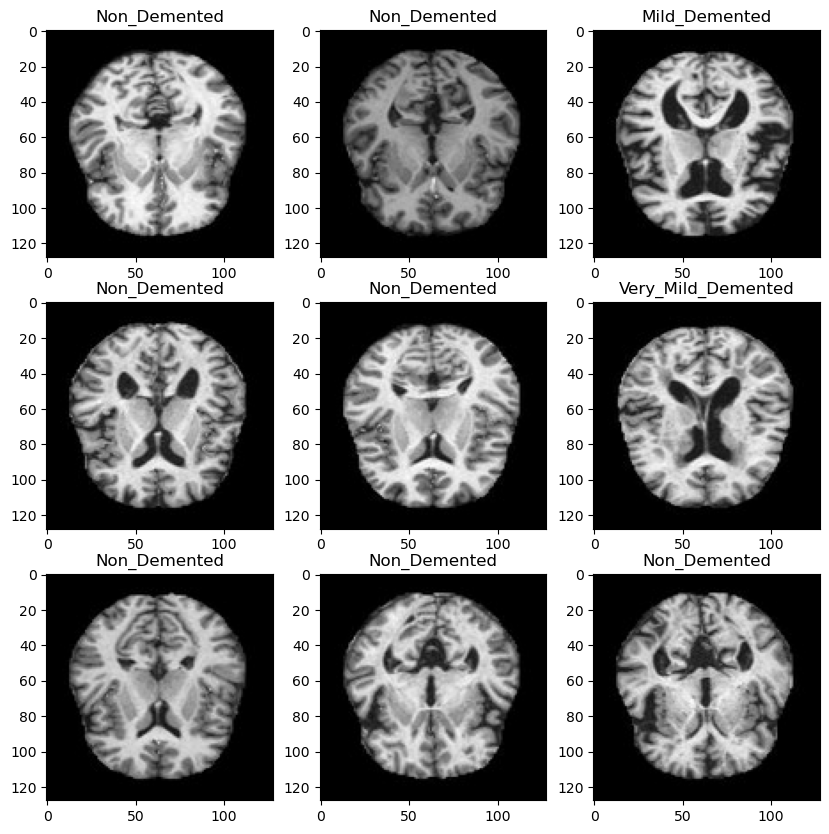

In [8]:
plt.figure(figsize=(10,10))
for image,label in train_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(class_name[label[i]])

In [11]:
data_dir='outputs'

In [12]:
os.listdir(data_dir)

['test', 'train', 'val']

In [19]:
os.listdir(os.path.join('outputs','train'))

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']

In [66]:
img=cv2.imread(os.path.join('outputs','train','Mild_Demented','mild_10.jpg'))

In [67]:
img

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

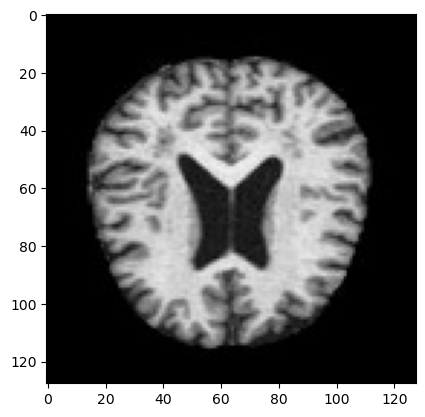

In [25]:
plt.imshow(img)


<function matplotlib.pyplot.show(close=None, block=None)>

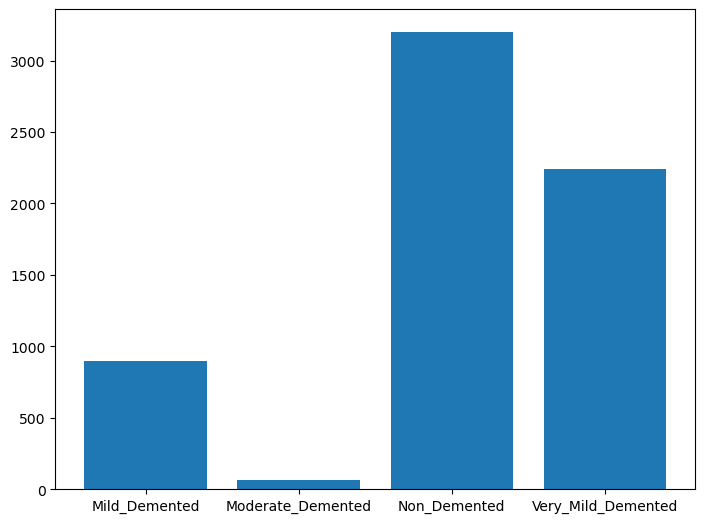

In [26]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
size = [896,64,3200,2240]
ax.bar(class_name,size)
plt.show

In [27]:
model = keras.models.Sequential()
model.add(keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT,IMG_WIDTH, 3)))
model.add(keras.layers.Conv2D(filters=16,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))


model.add(keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Dropout(0.20))

model.add(keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128,activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(64,"relu"))
model.add(keras.layers.Dense(4,"softmax"))

In [28]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = "Adam",metrics=["accuracy"])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0

In [30]:
hist = model.fit(train_ds,validation_data=val_ds,epochs=30, batch_size=64, verbose=1)

Epoch 1/30
80/80 [==============================] - 77s 888ms/step - loss: 1.1950 - accuracy: 0.4880 - val_loss: 0.9814 - val_accuracy: 0.5931
Epoch 2/30
80/80 [==============================] - 67s 832ms/step - loss: 0.9210 - accuracy: 0.5569 - val_loss: 0.8907 - val_accuracy: 0.5931
Epoch 3/30
80/80 [==============================] - 71s 887ms/step - loss: 0.8759 - accuracy: 0.5831 - val_loss: 0.7964 - val_accuracy: 0.6604
Epoch 4/30
80/80 [==============================] - 85s 1s/step - loss: 0.7860 - accuracy: 0.6480 - val_loss: 0.7383 - val_accuracy: 0.6651
Epoch 5/30
80/80 [==============================] - 54s 677ms/step - loss: 0.6990 - accuracy: 0.6997 - val_loss: 0.6076 - val_accuracy: 0.7653
Epoch 6/30
80/80 [==============================] - 59s 723ms/step - loss: 0.6097 - accuracy: 0.7400 - val_loss: 0.5151 - val_accuracy: 0.8138
Epoch 7/30
80/80 [==============================] - 58s 723ms/step - loss: 0.4724 - accuracy: 0.8129 - val_loss: 0.4480 - val_accuracy: 0.8075
Ep

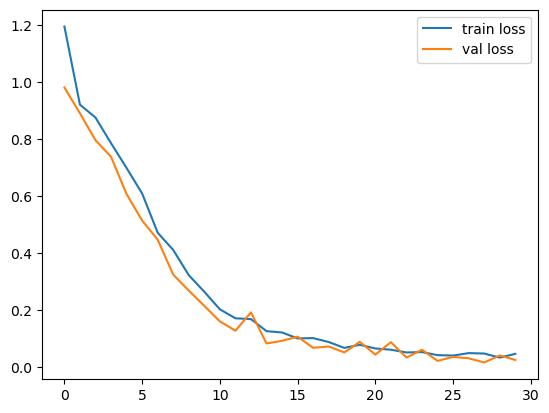

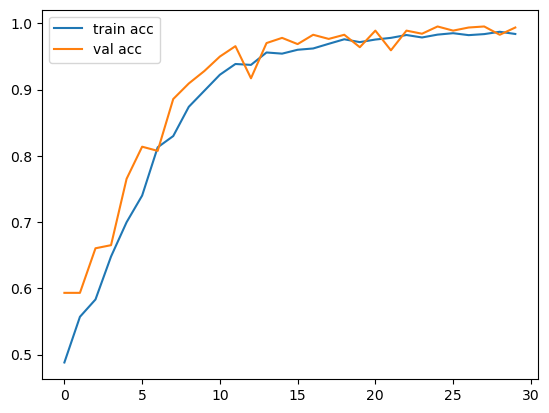

<Figure size 640x480 with 0 Axes>

In [31]:
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(hist.history['accuracy'], label='train acc')
plt.plot(hist.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [32]:

from tensorflow.keras.models import load_model

model.save('convolutional_2D.h5')

In [33]:
y_pred = model.predict(test_ds)

11/11 [==============================] - 7s 176ms/step


In [2]:
y_pred

NameError: name 'y_pred' is not defined

In [185]:
test_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [36]:
from tensorflow.keras.preprocessing import image
img=image.load_img('outputs/test/Very_Mild_Demented/verymild_1236.jpg',target_size=(128,128))

In [37]:
x=image.img_to_array(img)
img_data=preprocess_input(x)

In [39]:
x.shape

(128, 128, 3)

In [41]:
img_data.shape

(128, 128, 3)

In [14]:
y=x/128

In [15]:
from tensorflow.keras.applications.inception_v3 import preprocess_input
import numpy as np
x=np.expand_dims(y,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 128, 128, 3)